In [151]:
import numpy as np
import networkx as nx
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy
import pandas as pd
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
class _ListDict_(object):
    
    def __init__(self):
        self.item_to_position = {}
        self.items = []

    def __len__(self):
        return len(self.items)

    def add(self, item):
        if item in self.item_to_position:
            return
        self.items.append(item)
        self.item_to_position[item] = len(self.items)-1

    def remove(self, item):
        if item in self.item_to_position:
            position = self.item_to_position.pop(item)
            del self.items[position]
            for i in range(len(self.items)):
                if i >= position:
                    self.item_to_position[self.items[i]] = self.item_to_position[self.items[i]] - 1

    def choose_random(self):
        return random.choice(self.items)
    
    def __repr__(self):
         return repr(self.items)

    def __str__(self):
         return str(self.items)

In [3]:
def initialize_SIS_(G, initial_infecteds, infection_times, recovery_times, tmin):
    times = [tmin]
    S = [G.order()-len(initial_infecteds)]
    I = [len(initial_infecteds)]
    status = defaultdict(lambda:'S') #by default all are susceptible
    infected = list(initial_infecteds)
    infected_neighbor_count = defaultdict(lambda:0)
    risk_group = defaultdict(lambda:_ListDict_()) 
    
    for node in initial_infecteds:
        status[node] = 'I'
    for node in initial_infecteds:
        for neighbor in G.neighbors(node):
            if status[neighbor] == 'S':
                infected_neighbor_count[neighbor] += 1
                if infected_neighbor_count[neighbor] > 1:
                    risk_group[infected_neighbor_count[neighbor]-1].remove(
                                                                    neighbor)
                        
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)

    return times, S, I, status, infected, infected_neighbor_count, risk_group

In [4]:
def infect(G, S, I, R, times, infected, current_time, 
                        infected_neighbor_count, risk_group, status, 
                        infection_times):
    r = random.random()*sum(n*len(risk_group[n]) for n in risk_group.keys())
    
    for n in risk_group.keys():
        r -= n*len(risk_group[n])
        if r < 0:
            break
    #we've got n now

    recipient = risk_group[n].choose_random()
    
    risk_group[n].remove(recipient)
    infected.append(recipient)
    infection_times[recipient].append(current_time)
    status[recipient] = 'I'
    S.append(S[-1] - 1)
    I.append(I[-1] + 1)
    times.append(current_time)

    for neighbor in G.neighbors(recipient):
        if status[neighbor] == 'S':
            if infected_neighbor_count[neighbor] > 0:
                risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] += 1
            risk_group[infected_neighbor_count[neighbor]].add(neighbor)

In [5]:
def recover(G, S, I, times, infected, current_time, status, 
            infected_neighbor_count, risk_group, recovery_times):
    
    index = random.randint(0, I[-1] - 1)
    infected[index], infected[-1] = infected[-1], infected[index]
    recovering_node = infected.pop()

    I.append(I[-1] - 1)
    status[recovering_node] = 'S'
    S.append(S[-1] + 1)
    times.append(current_time)
    infected_neighbor_count[recovering_node] = 0
    
    for neighbor in G.neighbors(recovering_node):
        if neighbor == recovering_node:
            continue  #Deals with selfloops
                      #there is probably a good way to count the 
                      #number of infected neighbors
        if status[neighbor] == 'I':
            infected_neighbor_count[recovering_node] += 1
        else: #neighbor susceptible, its risk just got smaller
            risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] -= 1
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    if infected_neighbor_count[recovering_node]>0:
        risk_group[infected_neighbor_count[recovering_node]].add(recovering_node)

In [6]:
def SIS_detailed(G, tau, gamma, initial_infecteds = None, rho = None, tmin = 0, tmax = 100):

    infection_times = defaultdict(lambda: []) #defaults to an empty list 
    recovery_times = defaultdict(lambda: [])  #for each node

    tau = float(tau)  #just to avoid integer division problems.
    gamma = float(gamma)
    
    print("rho: ", rho)
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS_(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin)
    
    print("After initialization")
    print("times: ", times)
    print("S: ", S)
    print("I: ", I)
    print("Status: ", status)
    print("infected: ", infected)

    total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + random.expovariate(total_rate)
    
    while next_time < tmax and infected:
        r = random.random()*total_rate
        
        if r < total_rec_rate:
            print("recover")
            recover(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times)
            total_rec_rate = gamma*I[-1]
        else:
            print("infection")
            infect(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times)
            #updates variables as needed and calculates new max_trans_rate
        
        print("infected: ", infected)
        
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        if total_rate>0:
            next_time += random.expovariate(total_rate)
        else:
            next_time = float('Inf')
        

    return scipy.array(times), scipy.array(S), scipy.array(I)

In [7]:
def SIS(G, tau, gamma, initial_infecteds = None, rho = None, tmin = 0, tmax = 100):

    infection_times = defaultdict(lambda: []) #defaults to an empty list 
    recovery_times = defaultdict(lambda: [])  #for each node

    tau = float(tau)  #just to avoid integer division problems.
    gamma = float(gamma)
    
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS_(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin)
    
    total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + random.expovariate(total_rate)
    
    while next_time < tmax and infected:
        r = random.random()*total_rate
        
        if r < total_rec_rate:
            recover(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times)
            total_rec_rate = gamma*I[-1]
        else:
            infect(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times)
            #updates variables as needed and calculates new max_trans_rate
        
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        if total_rate>0:
            next_time += random.expovariate(total_rate)
        else:
            next_time = float('Inf')
        

    return scipy.array(times), scipy.array(S), scipy.array(I)

In [254]:
G = nx.DiGraph()
H = nx.path_graph(10)
G.add_nodes_from(H)
G.add_edges_from([(1, 2), (1, 3), (4, 1), (4, 9), (3, 4), (9, 4), \
                  (2, 8), (2, 6), (6, 7), (5, 0), (5, 7), (5, 6), \
                  (8, 0), (8, 5)])

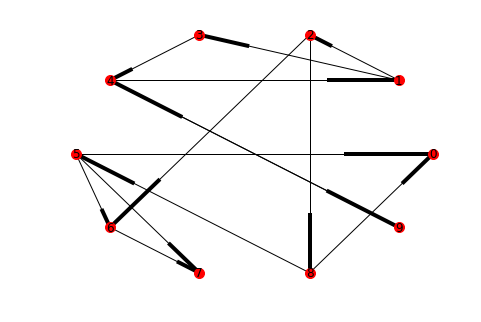

In [255]:
pos=nx.circular_layout(G)
nx.draw(G, pos, node_size = 100, with_labels=True)

In [260]:
for i in G.neighbors(1):
    print(i)

2
3


range(0, 3)


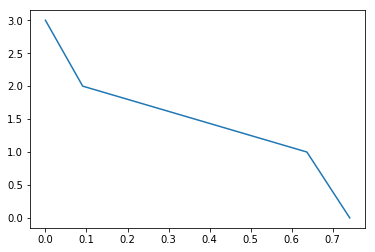

In [92]:
initial_size = 3
gamma = 1.
tau = 0.05
t, S, I = SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))

plt.plot(t, I)

### Семантическая сеть

In [299]:
df = pd.read_excel('assoc_eng.xlsx')
G = nx.from_pandas_dataframe(df, 'Source', 'Target', edge_attr=None, create_using=nx.DiGraph())

In [8]:
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvals(A))

In [9]:
max_eigval

(13.442729416193643+0j)

In [48]:
1 / max_eigval

(0.07438965473747916+0j)

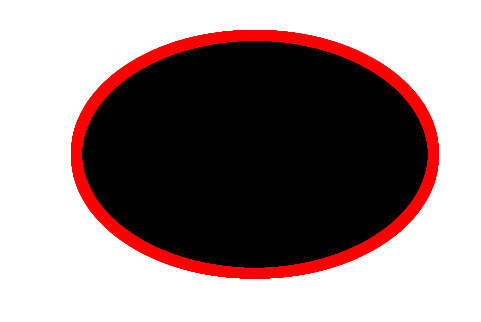

In [69]:
pos=nx.circular_layout(G)
nx.draw(G, pos, node_size = 100)#, with_labels=True)

In [8]:
G['LEG']

AtlasView({'ARM': {}, 'BODY': {}, 'BROKEN': {}, 'FOOT': {}, 'KNEE': {}, 'LONG': {}, 'MUSCLE': {}, 'RUN': {}, 'THIGH': {}, 'WALK': {}})

In [9]:
G.number_of_nodes()

5019

In [10]:
for i in G.neighbors('BAY'):
    print(i)

AREA
BOAT
FRONT
HARBOR
HORSE
LAKE
OCEAN
RIVER
SEA
SHORE
TAMPA
WATCH
WATER
WINDOW


In [115]:
for i in G.nodes:
    print(i)

A
ALPHABET
APPLE
GRADE
GREAT
LETTER
ONE
PLUS
WORD
AARDVARK
ANIMAL
ANT
ANTEATER
DICTIONARY
FUR
MUSIC
NOSE
SHELL
UGLY
ZOO
ABDOMEN
BELLY
BODY
CRAMP
INTESTINE
MUSCLE
ORGAN
PAIN
SEX
STOMACH
ABDUCT
CAPTURE
CHILD
KIDNAP
MISSING
OPEN
STEAL
TAKE
ABILITY
ABLE
ATHLETE
CAN
CAPABILITY
CAPACITY
COMPETENCE
DO
INABILITY
KNOWLEDGE
MIND
PHYSICAL
POTENTIAL
POWER
SKILL
SPORT
STRENGTH
TALENT
WORK
EASY
READY
STRONG
WELL
WILLING
ABNORMAL
CRAZY
DIFFERENT
INSANE
ME
NORMAL
ODD
PSYCHOLOGY
RETARDED
STRANGE
UNCOMMON
UNUSUAL
WEIRD
ABOVE
AVERAGE
BELOW
BEYOND
CLOUD
HIGH
OVER
SKY
TOP
UP
ABSENCE
ALONE
ATTENDANCE
AWAY
CLASS
EMPTY
EXCUSE
GOOD
HERE
ILLNESS
KIDS
NOT
PRESENCE
PRESENT
SCHOOL
SICK
TARDY
VOID
WITHOUT
ABSENT
GONE
LOST
MINDED
THERE
ABSTRACT
ART
BLACK
COMPLEX
CONCRETE
DRAW
GEOMETRY
IDEA
MATH
PAINTING
THINK
THOUGHT
UNCLEAR
WILD
ABSURD
DUMB
FUNNY
IMPOSSIBLE
NONSENSE
OUTRAGEOUS
RIDICULOUS
SILLY
STUPID
ABUNDANCE
FAMINE
FOOD
FULL
LACK
LARGE
LITTLE
LOTS
MANY
MONEY
MORE
MUCH
PEOPLE
PLENTY
SCARCITY
TREES
VARIETY
WATER
AB

RAIL
SCENE
VIEW
BALD
SCALP
SMOOTH
BALL
BAT
BOUNCE
CHAIN
BALLERINA
GRACEFUL
PINK
SHOE
SKINNY
SLIPPERS
TOE
TUTU
JAZZ
OPERA
FLOAT
HELIUM
POP
RUBBER
STRING
BALLOT
CAST
ELECT
ELECTION
VOTE
BAN
BLOCK
DEODORANT
PROHIBIT
REMOVE
GRAPE
PEEL
REPUBLIC
SLIP
SPLIT
STRAWBERRY
YELLOW
CLARINET
DRUM
FLUTE
INSTRUMENT
RAP
SONG
WAGON
BRUISE
GAUZE
WOUND
WRAP
HEAL
OUCH
PROTECT
SCRATCH
BANDANNA
CLOTH
COWBOY
GANG
HANDKERCHIEF
HAT
HEADBAND
RAG
SCARF
BANDIT
BURGLAR
CROOK
MASK
OUTLAW
PIRATE
RACCOON
ROBBER
BANG
BOOM
EXPLOSION
KNOCK
SMASH
BANJO
FIDDLE
LOAN
TELLER
VAULT
BANKER
BANNER
CELEBRATION
DINNER
FEAST
MEAL
BAPTIST
CATHOLIC
CHRISTIAN
JEWISH
METHODIST
MINISTER
PREACHER
PROTESTANT
RELIGION
RELIGIOUS
SOUTHERN
BARTENDER
CLUB
GRILL
POLE
PUB
STOOL
BEEF
COOKOUT
HAMBURGER
PIT
SAUCE
BARGAIN
BARTER
CHEAP
DEAL
MARKET
TRADE
BARK
MEOW
BARLEY
GRAIN
HAY
HERB
LEAF
MALT
OATS
TEA
WHEAT
BARN
LOFT
SHED
BARRACUDA
SHARK
BARREL
BUCKET
JUG
KEG
OIL
PICKLES
TUB
WHEEL
WHISKEY
BARRIER
BLOCKADE
BRIDGE
DAMN
FENCE
GATE
OBSTACLE
REEF
WALL
SE

INSTANCE
SURROUNDINGS
PARADE
MEMBER
CITRUS
COUNTY
SUBURB
STAKE
SUE
CLAIMS
TAXES
DIGGER
MUSSEL
OYSTER
SEAFOOD
CLAMP
FASTEN
GRIP
SHUT
SQUEEZE
TOW
VICE
CLARIFY
EXPLAIN
OBOE
RANK
LOBSTER
PLAY DOUGH
SPOTLESS
TIDY
FLUID
SCRUB
CLEANING
SPONGE
CRYSTAL
FOGGY
HAZE
TRANSPARENT
VIVID
CLENCH
FIST
GRASP
WRENCH
RECEPTIONIST
SALESMAN
TYPIST
CLEVER
CLICK
ON
TAP
TICK
DIVE
HANGER
TROPICAL
HEIGHT
LADDER
CLIMBER
HIKER
CLINIC
CLIPPERS
SCISSORS
SHEARS
TOENAIL
DAGGER
CLOCKWISE
DIRECTION
CLOG
DRAIN
CLOSING
ENDING
STATEMENT
COTTON
FABRIC
SILK
WARMTH
WIPE
FASHION
WARDROBE
FLUFFY
NINE
CLOVE
FOUR
GARLIC
SEASONING
JOKER
FRATERNITY
PARADISE
CLUE
HINT
PUZZLE
STUMBLE
CO-PILOT
COAL
FUEL
MINER
EASE
EAST
GLIDE
GUARD
SLIDE
HANG
MINK
COB
WEB
COBBLER
DESSERT
COBRA
DEADLY
STICKY
COCA-COLA
SOFT DRINK
THIRST
DOPE
POWDER
SNIFF
COCKTAIL
UMBRELLA
CODE
MORSE
NICKEL
QUARTER
FEVER
FLU
SHIVER
COLLAR
FLEA
SLEEVE
STARCH
DISPERSE
PASS OUT
TAX
EDUCATION
HIGH SCHOOL
COLOGNE
FRAGRANCE
COLONEL
LIEUTENANT
PRIVATE
HUE
RAINBOW
SHADE
COLT
MARE


ROOST
PERISCOPE
PERISH
PERJURY
PERSONNEL
TERMITE
PHASE
PIGMENT
SPIKE
STEWARDESS
PIOUS
PROCEDURE
STRATEGY
PLANNING
PLATFORM
PLAYTHING
PLAZA
UNPLEASANT
PLIERS
SCREWDRIVER
THEME
POPEYE
POACH
POEM
PROSE
SONNET
QUILL
STARBOARD
POSSUM
TREAT
PRICELESS
PRECIPICE
PREDATOR
PREFERENCE
PREMISES
PRINTING
PRIM
PRISM
STEPS
PROPOSAL
PROVIDENCE
PROVISION
PUBLICATION
TAPIOCA
PUN
VIOLET
Q-TIPS
QUAIL
SEMESTER
SCROLL
QUIVER
QUIZ
QUOTIENT
RACQUET
TURNIP
SCRAP
VIOLATION
RAPID
REMINISCENCE
RECLINER
RECOMMEND
RECOMMENDATION
RECRUIT
RECTANGLE
SLEIGH
UPTIGHT
REPLACE
REMOVER
RENOUNCE
REPENTANCE
SPAWN
REPULSIVE
SURVIVE
RESERVE
RESISTANCE
RESTORE
REVENGE
REVIVAL
REVOLUTION
RIB
SPARE
SQUAD
SHINGLE
TWINE
SANDPAPER
SOLE
RURAL
SABER
SALIVA
SALOON
SANDALS
SARDINE
SASH
SCOOP
UNDERWATER
WALRUS
SEASHORE
SEDATIVE
TENDER
SENTRY
SERIES
SERPENT
WIGGLE
SHEPHERD
SHINY
TREATMENT
SOCK
SPREE
SHORTCAKE
SHUTTER
SICKLE
STOPLIGHT
SILL
SIRLOIN
TOURIST
SITTING
TROUSERS
SLAY
SLENDER
SLING
SLITHER
SLIVER
SLUG
SLUMBER
SMELT
SPATULA
THRIFT
S

### Анализ

In [21]:
init_infected = random.sample(set(G.nodes), 100)

#init_infected = ['COTTAGE', 'SWISS', 'CAKE']

rho:  None
After initialization
times:  [0]
S:  [5016]
I:  [3]
Status:  defaultdict(<function initialize_SIS_.<locals>.<lambda> at 0x15109a6e18>, {'COTTAGE': 'I', 'SWISS': 'I', 'CAKE': 'I', 'CABIN': 'S', 'CHEESE': 'S', 'COUNTRY': 'S', 'HOME': 'S', 'HOUSE': 'S', 'HUT': 'S', 'LAKE': 'S', 'SMALL': 'S', 'WOODS': 'S', 'ACCOUNT': 'S', 'ARMY': 'S', 'BANK': 'S', 'CHEDDAR': 'S', 'CHOCOLATE': 'S', 'KNIFE': 'S', 'SKI': 'S', 'WATCH': 'S', 'BAKE': 'S', 'BIRTHDAY': 'S', 'COOKIE': 'S', 'CREAM': 'S', 'DIET': 'S', 'EAT': 'S', 'FAT': 'S', 'FOOD': 'S', 'FROSTING': 'S', 'GOOD': 'S', 'ICE CREAM': 'S', 'ICING': 'S', 'MIX': 'S', 'PARTY': 'S', 'PIE': 'S', 'SWEET': 'S', 'WALK': 'S', 'YUMMY': 'S'})
infected:  ['COTTAGE', 'SWISS', 'CAKE']
recover
infected:  ['CAKE', 'SWISS']
infection
infected:  ['CAKE', 'SWISS', 'ARMY']
infection
infected:  ['CAKE', 'SWISS', 'ARMY', 'FAT']
infection
infected:  ['CAKE', 'SWISS', 'ARMY', 'FAT', 'SLOB']
recover
infected:  ['SLOB', 'SWISS', 'ARMY', 'FAT']
infection
infected:  ['SLO

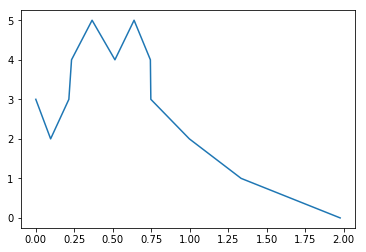

In [21]:
initial_size = 3
gamma = 1.
tau = 0.05
t, S, I = SIS_detailed(G, tau, gamma, tmax = 20,
                        initial_infecteds = init_infected)

plt.plot(t, I)

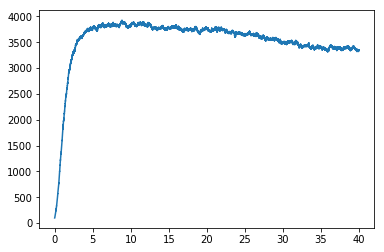

In [34]:
initial_size = 100
init_infected = random.sample(set(G.nodes), 100)
gamma = 1.
tau = 0.5
t, S, I = SIS(G, tau, gamma, tmax = 40, initial_infecteds = init_infected)

plt.plot(t, I)

In [9]:
def get_stability_time(inf_arr, num_steps, interval, eps, threshold):
    count = 0
    stab_time = num_steps
    for i, j in zip(np.arange(0, num_steps - interval, 1), np.arange(interval, num_steps, 1)):
        if abs(inf_arr[j] - inf_arr[i]) < eps:
            count += 1
        else:
            count = 0
        if count > threshold:
            stab_time = i
            break
    return stab_time        

## Ансамбль из 100 сетей изначально зараженных вершин

In [11]:
G = nx.from_pandas_dataframe(df, 'Source', 'Target', edge_attr=None, create_using=nx.DiGraph())
num_init_infected = 100
init_inf = random.sample(set(G.nodes), num_init_infected)

In [31]:
p_inf_arr = np.linspace(0.01, 0.2, 20)
p_inf_arr

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [32]:
initial_size = 100
gamma = 1.
t_stab = []
std_array = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    for i in range(100):
        t, S, I = SIS(G, prob, gamma, tmax = 20, initial_infecteds = init_inf)
        inf_array.append(I.tolist())
        
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len:
            last_elem = arr[-1]
            for j in range(max_len - len(arr)):
                arr.append(last_elem)
    
    ens_inf = np.stack((inf_array), axis = -1)
    std_inf = [np.std(lst) for lst in ens_inf]
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)
    
    std_array.append(std_inf[stab_time - 1])
    t_stab.append(t[stab_time - 1])

--------------------------------
infection probability:  0.01
--------------------------------
infection probability:  0.02
--------------------------------
infection probability:  0.03
--------------------------------
infection probability:  0.04
--------------------------------
infection probability:  0.05
--------------------------------
infection probability:  0.060000000000000005
--------------------------------
infection probability:  0.06999999999999999
--------------------------------
infection probability:  0.08
--------------------------------
infection probability:  0.09
--------------------------------
infection probability:  0.09999999999999999
--------------------------------
infection probability:  0.11
--------------------------------
infection probability:  0.12
--------------------------------
infection probability:  0.13
--------------------------------
infection probability:  0.14
--------------------------------
infection probability:  0.15000000000000002
---------

In [89]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')

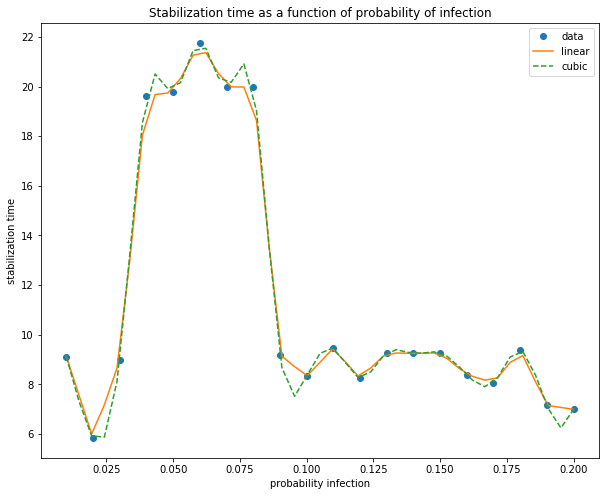

In [94]:
f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.01, 0.2, num=41, endpoint=True)
plt.title('Stabilization time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.plot(p_inf_arr, t_stab, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [91]:
std_array

[3.6252448193191036,
 6.771587701566007,
 3.4942667328067554,
 5.636266494764066,
 11.062205928294771,
 8.596621429375613,
 11.418734605900953,
 18.371529604254512,
 36.85541479891388,
 45.1619485850644,
 75.37400082256481,
 68.75841766649376,
 207.3791802471984,
 70.47748860451826,
 69.80561295483338,
 53.18232413123744,
 52.180528935609686,
 67.2608533992842,
 49.209019498461856,
 47.5077425268766]

Text(0.5,1,'SIS model on semantic network (ensemble)')

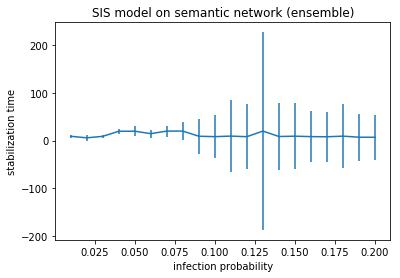

In [55]:
f = plt.figure()
plt.errorbar(p_inf_arr, t_stab, std_array)
plt.xlabel('infection probability')
plt.ylabel('stabilization time')
plt.title('SIS model on semantic network (ensemble)')

In [97]:
p_inf_arr = np.linspace(0.002, 0.2, 20)

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for i in range(100):
        t, S, I = SIS(G, prob, gamma, tmax = 20, initial_infecteds = init_inf)
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
        
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.002
--------------------------------
infection probability:  0.012421052631578947
--------------------------------
infection probability:  0.022842105263157893
--------------------------------
infection probability:  0.03326315789473684
--------------------------------
infection probability:  0.04368421052631579
--------------------------------
infection probability:  0.05410526315789474
--------------------------------
infection probability:  0.06452631578947368
--------------------------------
infection probability:  0.07494736842105264
--------------------------------
infection probability:  0.08536842105263158
--------------------------------
infection probability:  0.09578947368421052
--------------------------------
infection probability:  0.10621052631578948
--------------------------------
infection probability:  0.11663157894736842
--------------------------------
infection probability:  0.12705263157894736
-----------

In [98]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

Text(0,0.5,'number of infected')

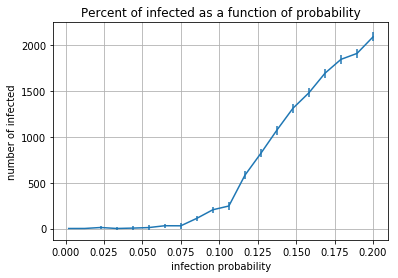

In [99]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, frac_arr, yerr = std_at_stab_time)
ax.grid(True)
ax.set_title('Percent of infected as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('number of infected')

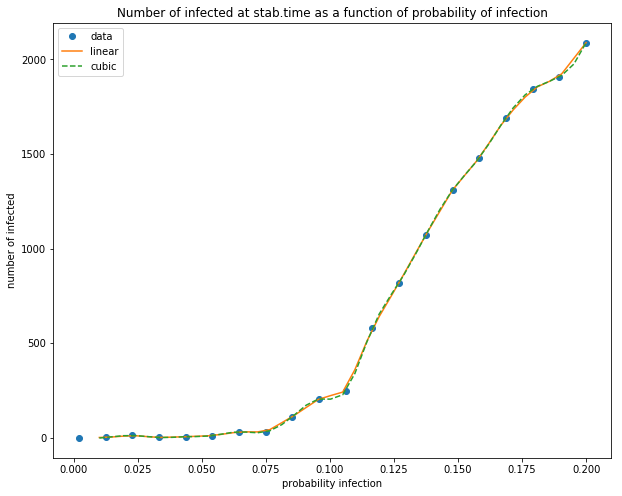

In [132]:
f1 = interp1d(p_inf_arr, frac_arr)
f2 = interp1d(p_inf_arr, frac_arr, kind='cubic')

f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.01, 0.2, num=41, endpoint=True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.plot(p_inf_arr, frac_arr, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [133]:
tau_arr = np.linspace(0.001, 0.2, 10)
tau_arr

array([0.001     , 0.02311111, 0.04522222, 0.06733333, 0.08944444,
       0.11155556, 0.13366667, 0.15577778, 0.17788889, 0.2       ])

In [139]:
initial_size = 100
gamma = 1.
tau = 0.004
init_inf = random.sample(set(G.nodes), initial_size)
I_arr, t_arr = [], []
for tau in (tau_arr):
    print(tau)
    t, S, I = SIS(G, tau, gamma, tmax = 150,
                        initial_infecteds = init_inf)
    I_arr.append(I)
    t_arr.append(t)

0.001
0.023111111111111114
0.045222222222222226
0.06733333333333334
0.08944444444444445
0.11155555555555556
0.13366666666666668
0.1557777777777778
0.1778888888888889
0.2


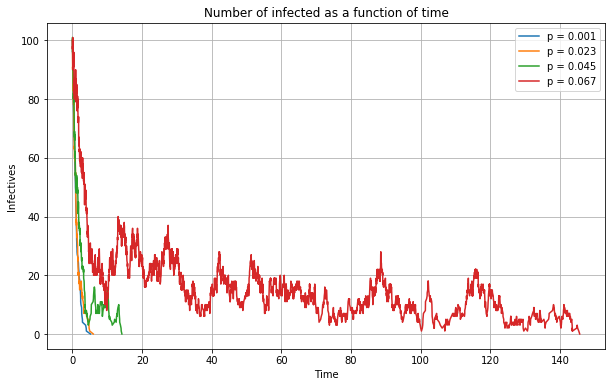

In [140]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

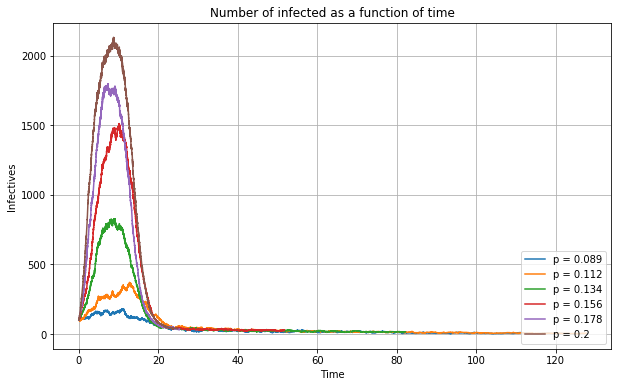

In [141]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label= "p = " + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label= "p = " + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label= "p = " + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label= "p = " + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label= "p = " + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label= "p = " + str(round(tau_arr[9], 3)))

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [145]:
initial_size = 500
gamma = 1.
init_inf = random.sample(set(G.nodes), initial_size)
I_arr, t_arr = [], []
for tau in (tau_arr):
    print(tau)
    t, S, I = SIS(G, tau, gamma, tmax = 40,
                        initial_infecteds = init_inf)
    I_arr.append(I)
    t_arr.append(t)

0.001
0.023111111111111114
0.045222222222222226
0.06733333333333334
0.08944444444444445
0.11155555555555556
0.13366666666666668
0.1557777777777778
0.1778888888888889
0.2


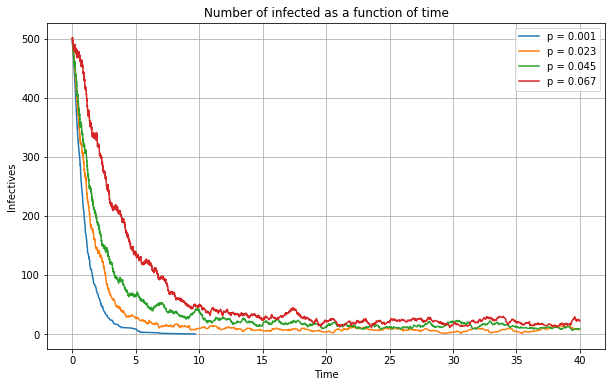

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

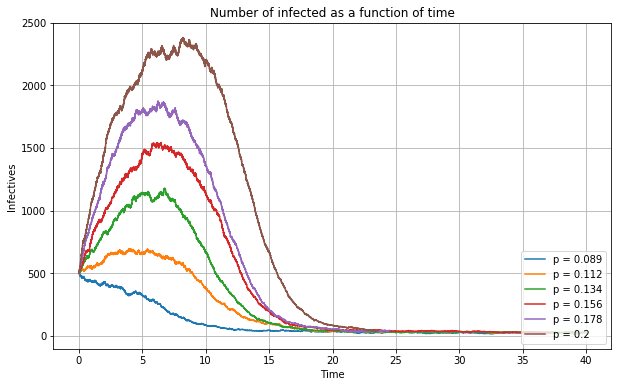

In [147]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label= "p = " + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label= "p = " + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label= "p = " + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label= "p = " + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label= "p = " + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label= "p = " + str(round(tau_arr[9], 3)))

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [125]:
tau_arr = np.linspace(0.05, 0.08, 10)
tau_arr

array([0.05      , 0.05333333, 0.05666667, 0.06      , 0.06333333,
       0.06666667, 0.07      , 0.07333333, 0.07666667, 0.08      ])

In [126]:
initial_size = 100
gamma = 1.
init_inf = random.sample(set(G.nodes), initial_size)
I_arr, t_arr = [], []
for tau in tau_arr:
    print('-----------')
    print(tau)
    inf_array = []
    t_array = []
    for i in range(100):
        t, S, I = SIS(G, tau, gamma, tmax = 50, initial_infecteds = init_inf)
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
        
    max_len = max([len(arr) for arr in inf_array])
    for arr, time in zip(inf_array, t_array):
        if len(arr) < max_len:
            last_elem_inf = arr[-1]
            last_elem_t = time[-1] + 1
            for j in range(max_len - len(arr)):
                arr.append(last_elem_inf)
                time.append(last_elem_t)
                last_elem_t += 1
                
    ens_inf = np.stack((inf_array), axis = -1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    
    I_arr.append(avrg_inf)
    t_arr.append(max(t_array))

-----------
0.05
-----------
0.05333333333333334
-----------
0.05666666666666667
-----------
0.06
-----------
0.06333333333333334
-----------
0.06666666666666667
-----------
0.07
-----------
0.07333333333333333
-----------
0.07666666666666666
-----------
0.08


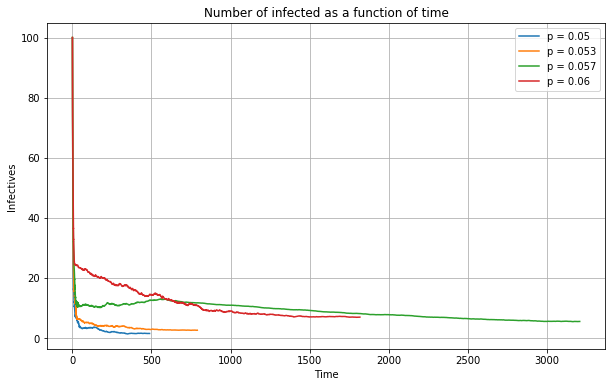

In [127]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

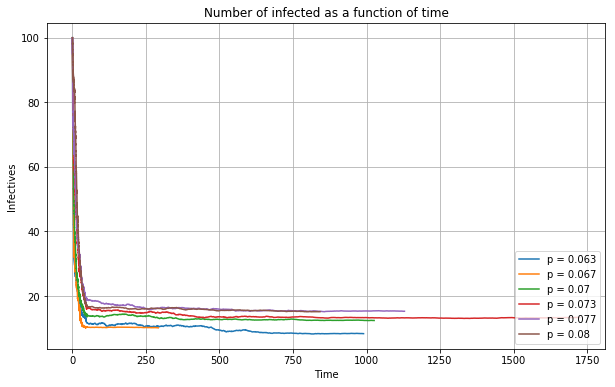

In [128]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label= "p = " + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label= "p = " + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label= "p = " + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label= "p = " + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label= "p = " + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label= "p = " + str(round(tau_arr[9], 3)))

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [76]:
initial_size = 100
gamma = 1.
I_arr, t_arr = [], []
tau_arr = np.linspace(0.005, 0.08, 10)
for tau in (tau_arr):
    I_tmp = []
    t_tmp = []
    for init_inf in init_infected_ensemble:
        t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = init_inf)
        I_tmp.append(I.tolist())
        t_tmp.append(t.tolist())
    
    #дозаполним число зараженных, преобразуем в усредненный список
    max_len_inf = max([len(arr) for arr in I_tmp])
    for arr in I_tmp:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    ens_inf = np.stack((I_tmp), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    I_arr.append(avrg_inf)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_tmp].index(max([len(arr) for arr in t_tmp]))
    t_arr.append(t_tmp[t_max_len])

In [77]:
tau_arr

array([0.005     , 0.01333333, 0.02166667, 0.03      , 0.03833333,
       0.04666667, 0.055     , 0.06333333, 0.07166667, 0.08      ])

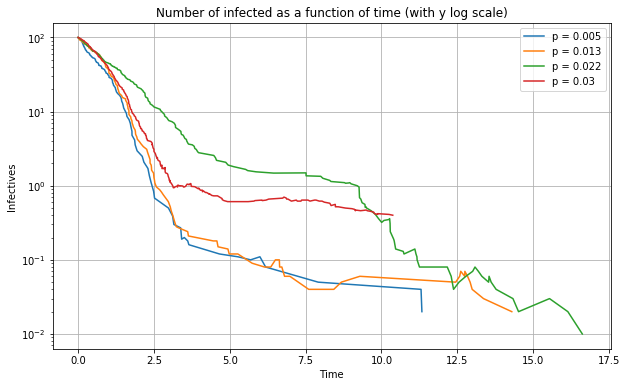

In [81]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label='p = ' + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label='p = ' + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label='p = ' + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label='p = ' + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

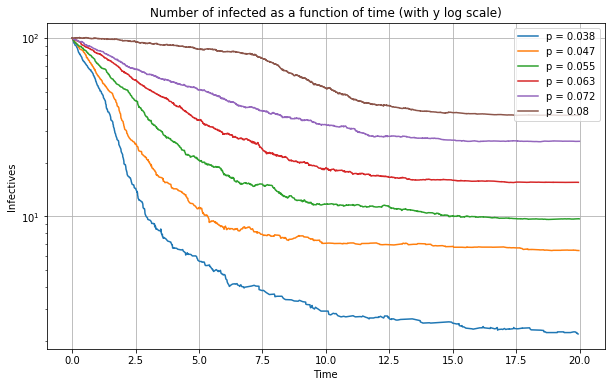

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.plot(t_arr[4], I_arr[4], label='p = ' + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label='p = ' + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label='p = ' + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label='p = ' + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label='p = ' + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label='p = ' + str(round(tau_arr[9], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

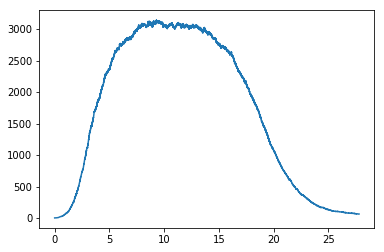

In [151]:
initial_size = 3
gamma = 1.
tau = 0.3
init_infected = random.sample(set(G.nodes), initial_size)
t, S, I = SIS(G, tau, gamma, tmax = 150, initial_infecteds = init_infected)

plt.plot(t, I)

Исследуем вероятность нахождения ответа

In [385]:
data = pd.read_excel("dataTR.xlsx")
data.head()

,Word1,Word2,Word3,Answer,Complexity
0,COTTAGE,SWISS,CAKE,CHEESE,0
1,CREAM,SKATE,WATER,ICE,0
2,LOSER,THROAT,SPOT,SORE,0
3,SHOW,LIFE,ROW,BOAT,0
4,NIGHT,WRIST,STOP,WATCH,0


In [380]:
data.loc[1][0]

'CREAM'

Сколько шагов надо сделать чтобы дойти до ответа?

In [12]:
def infect_with_infected(G, S, I, R, times, infected, current_time, 
                        infected_neighbor_count, risk_group, status, 
                        infection_times):
    r = random.random()*sum(n*len(risk_group[n]) for n in risk_group.keys())
    
    for n in risk_group.keys():
        r -= n*len(risk_group[n])
        if r < 0:
            break

    recipient = risk_group[n].choose_random()
    
    risk_group[n].remove(recipient)
    infected.append(recipient)
    infection_times[recipient].append(current_time)
    status[recipient] = 'I'
    S.append(S[-1] - 1)
    I.append(I[-1] + 1)
    times.append(current_time)

    for neighbor in G.neighbors(recipient):
        if status[neighbor] == 'S':
            if infected_neighbor_count[neighbor] > 0:
                risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] += 1
            risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    return infected

In [13]:
def recover_with_infected(G, S, I, times, infected, current_time, status, 
            infected_neighbor_count, risk_group, recovery_times):
    
    index = random.randint(0, I[-1] - 1)
    infected[index], infected[-1] = infected[-1], infected[index]
    recovering_node = infected.pop()

    I.append(I[-1] - 1)
    status[recovering_node] = 'S'
    S.append(S[-1] + 1)
    times.append(current_time)
    infected_neighbor_count[recovering_node] = 0
    
    for neighbor in G.neighbors(recovering_node):
        if neighbor == recovering_node:
            continue
        if status[neighbor] == 'I':
            infected_neighbor_count[recovering_node] += 1
        else:
            risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] -= 1
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    if infected_neighbor_count[recovering_node]>0:
        risk_group[infected_neighbor_count[recovering_node]].add(recovering_node)
    return infected

In [404]:
def SIS_with_infected(G, tau, gamma, initial_infecteds = None, rho = None, tmin = 0, tmax = 100, answer = None):

    infection_times = defaultdict(lambda: [])
    recovery_times = defaultdict(lambda: [])

    tau = float(tau)
    gamma = float(gamma)
    
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS_(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin)
    
    total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + 0.01
    
    inf_array = []
    inf_array.append(infected[:])
    
    while next_time < tmax and infected:
        r = random.random()*total_rate
        
        if r < total_rec_rate:
            recover_with_infected(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times)
            total_rec_rate = gamma*I[-1]
        else:
            infect_with_infected(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times)
        
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        next_time += 0.01
        
        inf_array.append(infected[:])
        

    return scipy.array(times), scipy.array(S), scipy.array(I), inf_array

['COTTAGE', 'SWISS', 'CAKE']
['COTTAGE', 'SWISS', 'CAKE', 'SWEET']
['COTTAGE', 'SWISS', 'CAKE', 'SWEET', 'SOUR']
['SOUR', 'SWISS', 'CAKE', 'SWEET']
['SOUR', 'SWISS', 'CAKE', 'SWEET', 'CANDY']
['SOUR', 'SWISS', 'CANDY', 'SWEET']
['SOUR', 'SWISS', 'CANDY', 'SWEET', 'BAD']
['SOUR', 'SWISS', 'BAD', 'SWEET']
['SOUR', 'SWISS', 'BAD']
['SOUR', 'BAD']
['SOUR', 'BAD', 'GIRL']
['SOUR', 'BAD']
['SOUR']
[]


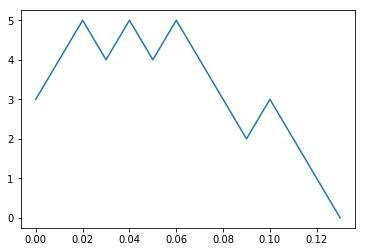

In [123]:
init_inf = [data.loc[0][0], data.loc[0][1], data.loc[0][2]]
gamma = 1.
tau = 0.05
t, S, I, inf_array = SIS_with_infected(G, tau, gamma, tmax = 20, initial_infecteds = init_inf, answer = data.loc[0][3])
for i in inf_array:
    print(i)
plt.plot(t, I)

In [142]:
inf_set = set([item for sublist in inf_array for item in sublist])

In [169]:
inf_array

[['COTTAGE', 'SWISS', 'CAKE'],
 ['COTTAGE', 'SWISS', 'CAKE', 'SWEET'],
 ['COTTAGE', 'SWISS', 'CAKE', 'SWEET', 'SOUR'],
 ['SOUR', 'SWISS', 'CAKE', 'SWEET'],
 ['SOUR', 'SWISS', 'CAKE', 'SWEET', 'CANDY'],
 ['SOUR', 'SWISS', 'CANDY', 'SWEET'],
 ['SOUR', 'SWISS', 'CANDY', 'SWEET', 'BAD'],
 ['SOUR', 'SWISS', 'BAD', 'SWEET'],
 ['SOUR', 'SWISS', 'BAD'],
 ['SOUR', 'BAD'],
 ['SOUR', 'BAD', 'GIRL'],
 ['SOUR', 'BAD'],
 ['SOUR'],
 []]

In [279]:
inf_set_with_neighbors = set()
for i in range(len(list(inf_set))):
    for word in G.neighbors(list(inf_set)[i]):
        print(word)
        inf_set_with_neighbors.add(word)
    print("---------")

BOY
FEMALE
FRIEND
GUY
INNOCENCE
LADY
PRETTY
WOMAN
---------
BAD
BITTER
CANDY
CREAM
DOUGH
GRAPE
LEMON
MILK
SALT
SWEET
TART
TASTE
---------
BAKE
BIRTHDAY
CHOCOLATE
COOKIE
CREAM
DIET
EAT
FAT
FOOD
FROSTING
GOOD
ICE CREAM
ICING
MIX
PARTY
PIE
SWEET
WALK
YUMMY
---------
APPLE
BABY
BAR
CALORIES
CANE
CHILD
CHOCOLATE
FATTENING
GOOD
GUM
JUNK
STORE
SUGAR
SWEET
---------
BOY
BREATH
COMPANY
CRIME
DOG
GIRL
GOOD
NEWS
TEMPER
---------
BITTER
CANDY
CHOCOLATE
GOOD
KIND
MEAN
NICE
POTATO
SOUR
SUGAR
TASTE
TOOTH
---------
ACCOUNT
ARMY
BANK
CHEDDAR
CHEESE
CHOCOLATE
KNIFE
SKI
WATCH
---------
CABIN
CHEESE
COUNTRY
HOME
HOUSE
HUT
LAKE
SMALL
WOODS
---------


In [276]:
inf_set

{'BAD', 'CAKE', 'CANDY', 'COTTAGE', 'GIRL', 'SOUR', 'SWEET', 'SWISS'}

In [264]:
H = G.subgraph(list(inf_set_with_neighbors))

(-0.10345983456238173,
 1.1015848769794683,
 -0.07438396211713552,
 1.0961869276687501)

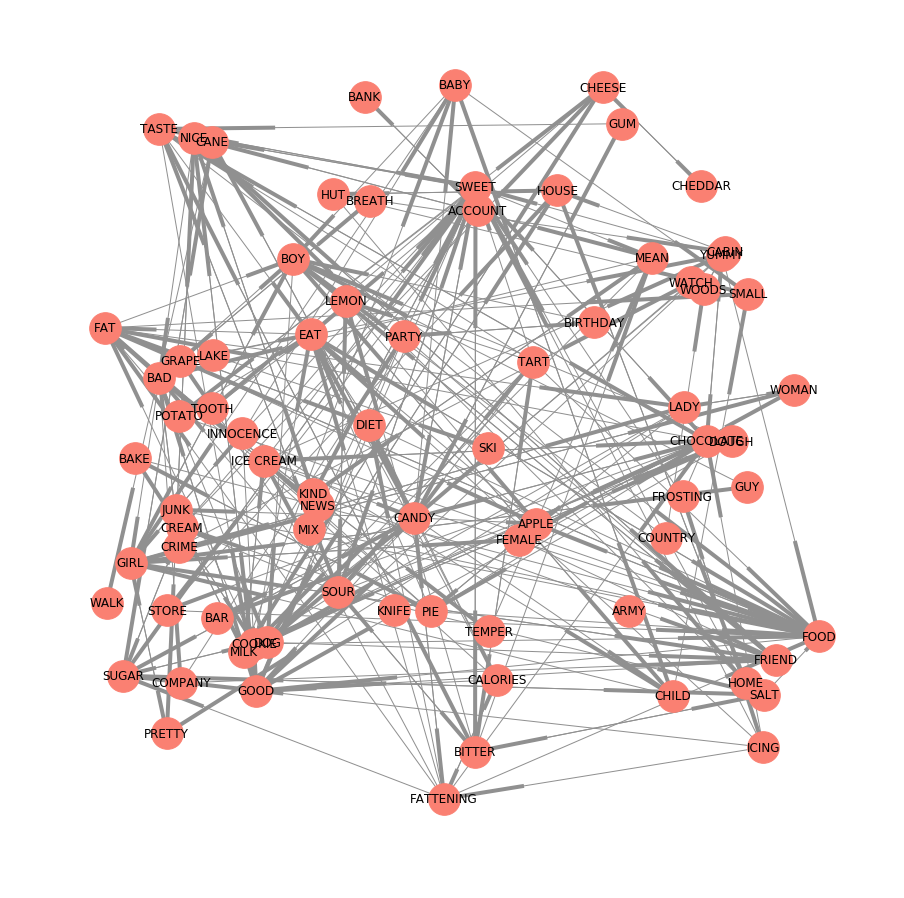

In [283]:
GG=nx.DiGraph()
H = G.subgraph(list(inf_set_with_neighbors))
GG.add_nodes_from(H.nodes)
GG.add_edges_from(H.edges)

labels = {}
for node in H.nodes():
    labels[node] = node
plt.figure(1, figsize=(12,12))
nx.draw_random(GG, node_color='salmon', edge_color='#909090', node_size=1000, labels=labels)

plt.axis('off')

(-1.2099999418216294,
 1.2099999944717386,
 -1.1619134058388503,
 1.1923681220003677)

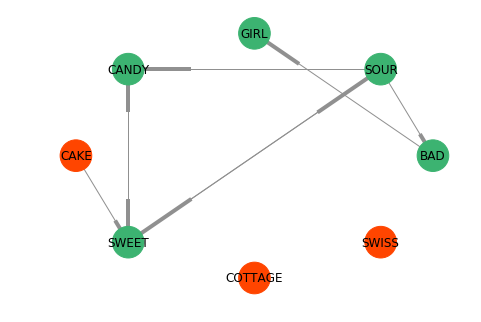

In [308]:
GG=nx.DiGraph()
H = G.subgraph(list(inf_set))
GG.add_nodes_from(H.nodes)
GG.add_edges_from(H.edges)

labels = {}
for node in H.nodes():
    labels[node] = node
plt.figure(1, figsize=(6,4))

color_map = []
for node in GG:
    if node in inf_array[0]:
        color_map.append('orangered')
    else: color_map.append('mediumseagreen') 
        
nx.draw_circular(GG, node_color=color_map, edge_color='#909090', node_size=1000, labels=labels)

plt.axis('off')

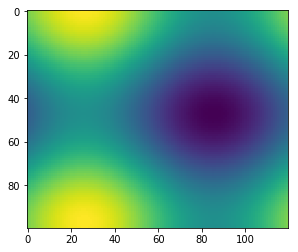

In [311]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
plt.show()

/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


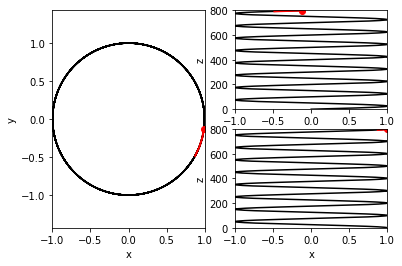

In [331]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation


class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 4)

        self.t = np.linspace(0, 80, 400)
        self.x = np.cos(2 * np.pi * self.t / 10.)
        self.y = np.sin(2 * np.pi * self.t / 10.)
        self.z = 10 * self.t

        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        self.line1 = Line2D([], [], color='black')
        self.line1a = Line2D([], [], color='red', linewidth=2)
        self.line1e = Line2D(
            [], [], color='red', marker='o', markeredgecolor='r')
        ax1.add_line(self.line1)
        ax1.add_line(self.line1a)
        ax1.add_line(self.line1e)
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-2, 2)
        ax1.set_aspect('equal', 'datalim')

        ax2.set_xlabel('y')
        ax2.set_ylabel('z')
        self.line2 = Line2D([], [], color='black')
        self.line2a = Line2D([], [], color='red', linewidth=2)
        self.line2e = Line2D(
            [], [], color='red', marker='o', markeredgecolor='r')
        ax2.add_line(self.line2)
        ax2.add_line(self.line2a)
        ax2.add_line(self.line2e)
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(0, 800)

        ax3.set_xlabel('x')
        ax3.set_ylabel('z')
        self.line3 = Line2D([], [], color='black')
        self.line3a = Line2D([], [], color='red', linewidth=2)
        self.line3e = Line2D(
            [], [], color='red', marker='o', markeredgecolor='r')
        ax3.add_line(self.line3)
        ax3.add_line(self.line3a)
        ax3.add_line(self.line3e)
        ax3.set_xlim(-1, 1)
        ax3.set_ylim(0, 800)

        animation.TimedAnimation.__init__(self, fig, interval=50, blit=True)

    def _draw_frame(self, framedata):
        i = framedata
        head = i - 1
        head_slice = (self.t > self.t[i] - 1.0) & (self.t < self.t[i])

        self.line1.set_data(self.x[:i], self.y[:i])
        self.line1a.set_data(self.x[head_slice], self.y[head_slice])
        self.line1e.set_data(self.x[head], self.y[head])

        self.line2.set_data(self.y[:i], self.z[:i])
        self.line2a.set_data(self.y[head_slice], self.z[head_slice])
        self.line2e.set_data(self.y[head], self.z[head])

        self.line3.set_data(self.x[:i], self.z[:i])
        self.line3a.set_data(self.x[head_slice], self.z[head_slice])
        self.line3e.set_data(self.x[head], self.z[head])

        self._drawn_artists = [self.line1, self.line1a, self.line1e,
                               self.line2, self.line2a, self.line2e,
                               self.line3, self.line3a, self.line3e]

    def new_frame_seq(self):
        return iter(range(self.t.size))

    def _init_draw(self):
        lines = [self.line1, self.line1a, self.line1e,
                 self.line2, self.line2a, self.line2e,
                 self.line3, self.line3a, self.line3e]
        for l in lines:
            l.set_data([], [])

ani = SubplotAnimation()
ani.save('test_sub.htm')
plt.show()

/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


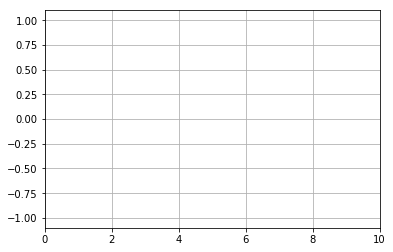

In [341]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, blit=False, interval=10,
                              repeat=False, init_func=init)
ani.save('test_sub.htm')

/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


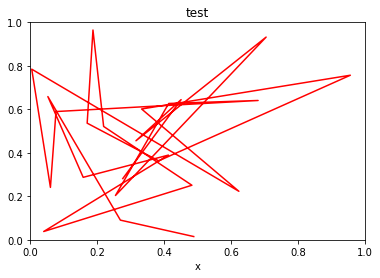

In [344]:
def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)
line_ani.save('line_ani.htm')

Traceback (most recent call last):
  File "/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 389, in process
    proxy(*args, **kwargs)
  File "/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1081, in _start
    self._init_draw()
  File "/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1792, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1819, in _draw_frame
    for a in self._drawn_artists:
TypeError: 'int' object is not iterable
/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s 

IndexError: list index out of range

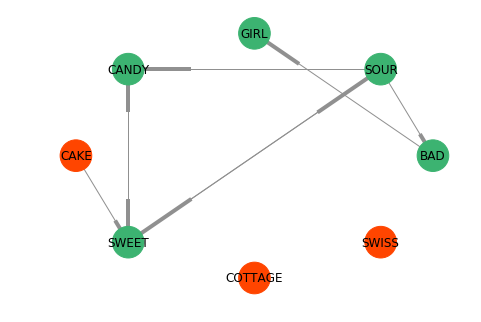

In [346]:
def update_graph(graph):
    return graph

fig1 = plt.figure()

GG=nx.DiGraph()
H = G.subgraph(list(inf_set))
GG.add_nodes_from(H.nodes)
GG.add_edges_from(H.edges)

labels = {}
for node in H.nodes():
    labels[node] = node
plt.figure(1, figsize=(6,4))

color_map = []
for node in GG:
    if node in inf_array[0]:
        color_map.append('orangered')
    else: color_map.append('mediumseagreen') 
        
nx.draw_circular(GG, node_color=color_map, edge_color='#909090', node_size=1000, labels=labels)

plt.axis('off')

line_ani = animation.FuncAnimation(fig1, update_graph, 25, fargs=(data, l),
                                   interval=50, blit=True)
line_ani.save('graph.htm')

### Гипотеза 1:
Время решения теста прямо пропорционально сложности теста

ANSWER 0.12999999999999998
ANSWER 0.13999999999999999
ANSWER 0.15
ANSWER 0.16
ANSWER 0.17
ANSWER 0.18000000000000002
['COTTAGE', 'SWISS', 'CAKE']
['COTTAGE', 'SWISS', 'CAKE', 'HUT']
['COTTAGE', 'SWISS', 'HUT']
['COTTAGE', 'SWISS']
['SWISS']
['SWISS', 'BANK']
['SWISS', 'BANK', 'VAULT']
['SWISS', 'VAULT']
['SWISS']
['SWISS', 'WATCH']
['SWISS', 'WATCH', 'OUT']
['SWISS', 'WATCH']
['SWISS', 'WATCH', 'CHEESE']
['SWISS', 'WATCH', 'CHEESE', 'WINE']
['SWISS', 'WATCH', 'CHEESE', 'WINE', 'SKI']
['SWISS', 'WATCH', 'CHEESE', 'WINE', 'SKI', 'ARMY']
['SWISS', 'WATCH', 'CHEESE', 'WINE', 'SKI', 'ARMY', 'CAKE']
['SWISS', 'WATCH', 'CHEESE', 'WINE', 'CAKE', 'ARMY']
['SWISS', 'WATCH', 'ARMY', 'WINE', 'CAKE']
['SWISS', 'WATCH', 'ARMY', 'WINE', 'CAKE', 'SERVICE']
['SWISS', 'SERVICE', 'ARMY', 'WINE', 'CAKE']
['SWISS', 'SERVICE', 'ARMY', 'WINE', 'CAKE', 'CHURCH']
['SWISS', 'SERVICE', 'ARMY', 'CHURCH', 'CAKE']
['CAKE', 'SERVICE', 'ARMY', 'CHURCH']
['CAKE', 'SERVICE', 'ARMY']
['CAKE', 'SERVICE', 'ARMY', 'HELP']


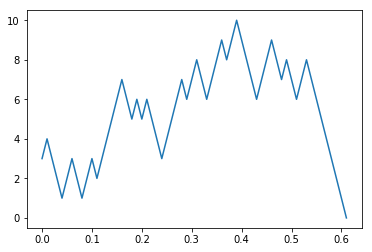

In [362]:
init_inf = [data.loc[0][0], data.loc[0][1], data.loc[0][2]]
gamma = 1.
tau = 0.05
t, S, I, inf_array = SIS_with_infected(G, tau, gamma, tmax = 20, initial_infecteds = init_inf, answer = data.loc[0][3])
for i in inf_array:
    print(i)
plt.plot(t, I)

In [359]:
def get_complexity(infected_array, answer):
    num = 0
    for i, arr in enumerate(infected_array):
        if answer in arr:
            num = i
            break
    return num

In [367]:
def get_time_answer(G, tau, gamma, init_inf, answer):
    t, S, I, inf_array = SIS_with_infected(G, tau, gamma, tmax = 20, initial_infecteds = init_inf, answer = data.loc[0][3])

    time_compl = get_complexity(inf_array, data.loc[0][3])
    return time_compl

In [363]:
get_complexity(inf_array, data.loc[0][3])

12

In [456]:
compl_light_arr = []
compl_medium_arr = []
compl_hard_arr = []

tau = 0.08
gamma = 1.

for i in range(len(data)):
    init_inf = [data.loc[i][0], data.loc[i][1], data.loc[i][2]]
    answer = data.loc[i][3]
    if data.loc[i]['Complexity'] == 0:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_light_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 1:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_medium_arr.append(np.mean(tmp))
    elif data.loc[i]['Complexity'] == 2:
        tmp = []
        for j in range(100):
            tmp.append(get_time_answer(G, tau, gamma, init_inf, answer))
        compl_hard_arr.append(np.mean(tmp))
            
print("Light: ", np.mean(compl_light_arr))
print("Medium: ", np.mean(compl_medium_arr))
print("Hard: ", np.mean(compl_hard_arr))

Light:  151.67862068965516
Medium:  180.00553191489362
Hard:  191.5275


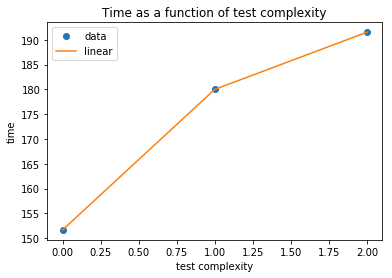

In [457]:
x = np.arange(0, 3, 1)
y = [np.mean(compl_light_arr), np.mean(compl_medium_arr), np.mean(compl_hard_arr)]
f1 = interp1d(x, y)

f = plt.figure(figsize=(6,4))
xnew = np.linspace(0.001, 2, num=41, endpoint=True)
plt.title('Time as a function of test complexity')
plt.xlabel('test complexity')
plt.ylabel('time')
plt.plot(x, y, 'o', xnew, f1(xnew), '-')
plt.legend(['data', 'linear'], loc='best')
plt.show()

Text(0,0.5,'time')

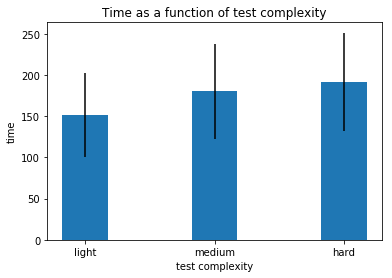

In [458]:
N = 3
ind = np.arange(N)
width = 0.35
std_arr = [np.std(compl_light_arr), np.std(compl_medium_arr), np.std(compl_hard_arr)]
plt.bar(ind, y, width, yerr=std_arr)
plt.xticks(ind, ('light', 'medium', 'hard'))
plt.title('Time as a function of test complexity')
plt.xlabel('test complexity')
plt.ylabel('time')

1. распределение по степеням (in and out - bernoili and powerlaw)
2. какие слова остаются активными в конце (степени слов, почему именно они () хабы или нет)
3. делать другие ансамбли (для определенных зараженных)
4. исследовать самые богатые по степени зараженные вершины ()
5. сделать для легких и тяжелых тестов (внутри ансамбль)
6. увеличить время и посмотреть